In [13]:
import tensorflow as tf
import os
import glob
import numpy as np

# 1. Test 이미지 파일 로드

In [2]:
name_test = 'objectdetection_test'
#파일의 path(디렉토리)는 절대경로를 사용하였으므로, Local PC에 맞는 Directory로 변경할 것. 
path_dict_test = {name_test : r"//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/test/"}
data_path_test = path_dict_test[name_test]
files_test = glob.glob('{}/*.jpg'.format(data_path_test))
print(files_test)

['//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/test/beer_0128.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/test/milk_0100.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/test/beer_0289.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/test/egg_0140.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/test/beer_0276.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/test/beer_0075.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/test/mandarin_0077.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/test/egg_0169.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/test/milk_0115.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detect

# 2. Train이미지 파일 로드

In [3]:
name_train = 'objectdetection_train'
path_dict_train = {name_train : r"//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/train/"}
data_path_train = path_dict_train[name_train]
files_train = glob.glob('{}/*.jpg'.format(data_path_train))
print(files_train)

['//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/train/soju_0211.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/train/soju_0205.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/train/soju_0239.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/train/egg_0222.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/train/beer_0114.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/train/beer_0100.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/train/egg_0236.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/train/soju_0013.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/train/soju_0007.jpg', '//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/d

In [4]:
#test와 train이미지 파일의 갯수 확인
print("train :",len(files_train),",","test :",len(files_test))

train : 1341 , test : 165


# 3. 이미지 Show

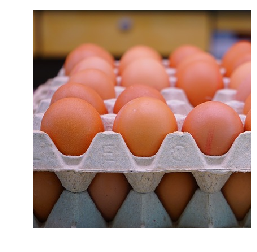

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i, img_path in enumerate(files_test):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  #plt.show()

# 4. Object의 Bounding Box를 그리는 함수 생성 

In [16]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
            25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

# (만약 설치가 안되어 있다면) tensorflow_hub설치 명렁어

In [17]:
!pip install tensorflow_hub

In [18]:
import tensorflow_hub as hub
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
from tqdm import tqdm

In [9]:
sample_image_path = "//Users/jooyoungson/Documents/MachineLearning/prography_5th_dl/detection_dataset/train/soju_0211.jpg"

with tf.Graph().as_default():
    # Create our inference graph
    image_string_placeholder = tf.placeholder(tf.string)
    decoded_image = tf.image.decode_jpeg(image_string_placeholder)
    decoded_image_float = tf.image.convert_image_dtype(
        image=decoded_image, dtype=tf.float32
    )
    # Expanding image from (height, width, 3) to (1, height, width, 3)
    image_tensor = tf.expand_dims(decoded_image_float, 0)

    # Load the model from tfhub.dev, and create a detector_output tensor
    model_url = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
    detector = hub.Module(model_url)
    detector_output = detector(image_tensor, as_dict=True)
    
    # Initialize the Session
    init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]
    sess = tf.Session()
    sess.run(init_ops)

    # Load our sample image into a binary string
    with tf.gfile.Open(sample_image_path, "rb") as binfile:
        image_string = binfile.read()

    # Run the graph we just created
    result_out, image_out = sess.run(
        [detector_output, decoded_image],
        feed_dict={image_string_placeholder: image_string}
    )

In [10]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

In [11]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image)

Font not found, using default font.


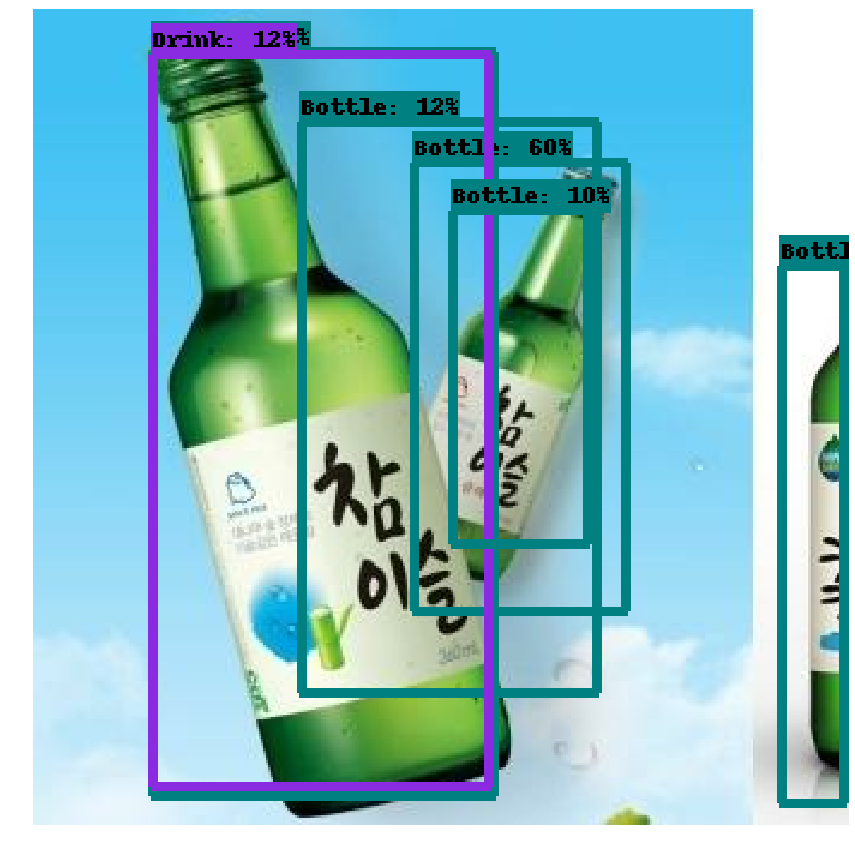

In [14]:
image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"]
)
display_image(image_with_boxes)